In [154]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes
from pycocotools.coco import COCO
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
%matplotlib inline

In [155]:
def get_transforms(train=False, image_width=2600, image_height=1600):
    if train:
        transform = A.Compose([
            A.Resize(image_height, image_width),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [156]:
class StreetTradersDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        super().__init__(root, transforms, transform, target_transform)
        self.split = split
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target]
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [[box[0], box[1], box[0] + box[2], box[1] + box[3]] for box in boxes]
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} 
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [157]:
dataset_path = "PATH_TO_YOUR_DATA"

In [ ]:
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())

In [136]:
classes = [i[1]['name'] for i in categories.items()]

In [148]:
train_dataset = StreetTradersDetection(root=dataset_path, transforms=get_transforms(True))

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


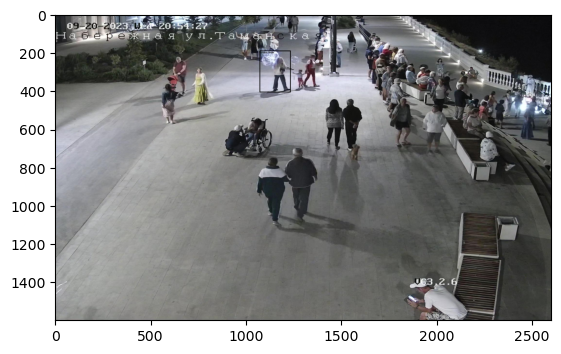

In [139]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [140]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
images,targets = next(iter(train_loader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)
device = torch.device("cuda")

In [ ]:
detection_models = [torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True), 
          torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True), 
          torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)]
for model in detection_models[:2]:
    in_features = model.roi_heads.box_predictor.cls_score.in_features # we need to change the head
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.0001, momentum=0.9, nesterov=True, weight_decay=1e-4)
    epochs=5
    train_model(model, optimizer, train_loader, epochs)

In [82]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [83]:
import sys

In [161]:
def train_model(model, optimizer, loader, epoch):
    for epoch in range(epochs):
        model.train()
        all_losses = []
        all_losses_dict = []
    
        for images, targets in tqdm(loader):
            images = list(image for image in images)
            targets = [{k: torch.tensor(v) for k, v in t.items()} for t in targets]
        
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
            loss_value = losses.item()
        
            all_losses.append(loss_value)
            all_losses_dict.append(loss_dict_append)
        
            if not math.isfinite(loss_value):
                print(f"Loss is {loss_value}, stopping trainig")
                print(loss_dict)
                sys.exit(1)
            try:
                pass
            except:
                pass
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
        all_losses_dict = pd.DataFrame(all_losses_dict)
        print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
            epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
            all_losses_dict['loss_classifier'].mean(),
            all_losses_dict['loss_box_reg'].mean(),
            all_losses_dict['loss_rpn_box_reg'].mean(),
            all_losses_dict['loss_objectness'].mean()
        ))

In [163]:
model = detection_models[0]

In [164]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
test_dataset = StreetTradersDetection(root=dataset_path, split="test", transforms=get_transforms(False))

In [166]:
img, _ = test_dataset[6]
img_int = torch.tensor(img*255, dtype=torch.uint8)
with torch.no_grad():
    prediction = model([img])
    pred = prediction[0]

In [ ]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.3],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.3].tolist()], width=4
).permute(1, 2, 0))

In [168]:
for i in range(len(detection_models)):
    torch.save(detection_models[i], f"model{i}.pt")